## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [753]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

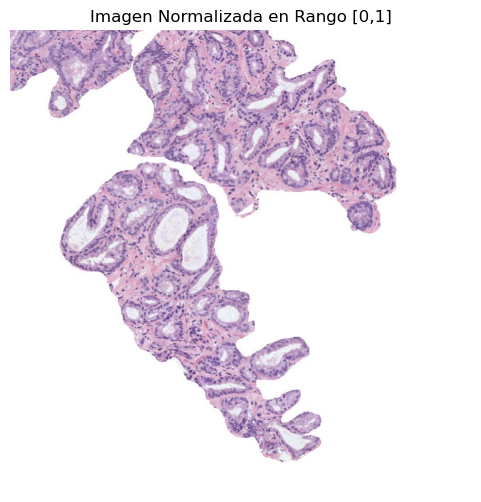

In [754]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure, morphology
import numpy as np
import matplotlib.pyplot as plt


# ===========================================================
# 1. Lectura de la imagen en formato RGB
# ===========================================================

# En este paso leo la imagen histológica original en formato RGB.
# La imagen debe estar en la misma carpeta del notebook.
img = io.imread('histo_2.jpg')

# ===========================================================
# 2. Normalización de la imagen al rango [0, 1]
# ===========================================================

# Convierto los valores de los píxeles (0–255) a flotantes en el rango [0, 1].
# Esto facilita el procesamiento posterior.
img_norm = img / 255.0

# ===========================================================
# 3. Visualización de la imagen normalizada
# ===========================================================

plt.figure(figsize=(6,6))
plt.imshow(img_norm)
plt.title("Imagen Normalizada en Rango [0,1]")
plt.axis("off")
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [755]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

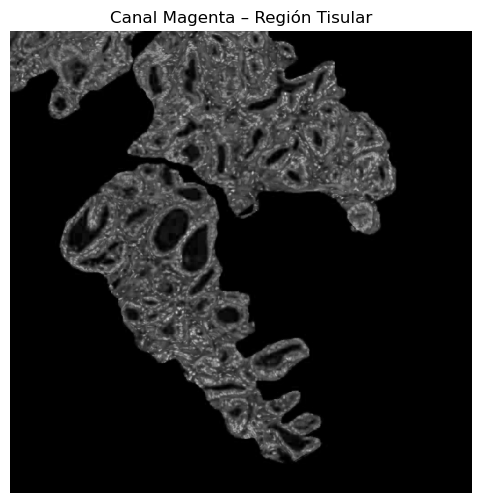

In [ ]:
# ============================================================
# PREGUNTA 01: Transformación de color y extracción del canal magenta
# ============================================================


from skimage import io
import matplotlib.pyplot as plt
import numpy as np



# 2. Normalizo la imagen para trabajar con valores entre 0 y 1
img_norm = img / 255.0

# 3. Realizo la conversión del espacio RGB a CMY
# (CMY = 1 - RGB)
# Luego, para obtener el canal K (negro), calculo el mínimo de las tres componentes.
C = 1 - img_norm[:, :, 0]
M = 1 - img_norm[:, :, 1]
Y = 1 - img_norm[:, :, 2]
K = np.min([C, M, Y], axis=0)

# 4. Obtengo las componentes CMYK
# Restando el componente negro de los tres primeros canales
C_final = (C - K) / (1 - K + 1e-6)
M_final = (M - K) / (1 - K + 1e-6)
Y_final = (Y - K) / (1 - K + 1e-6)

# 5. Extraigo la componente magenta (M_final)
# Esta componente resalta el tejido, ya que las zonas tisulares tienen alta absorción
# en el canal magenta, especialmente en imágenes histológicas teñidas.
magenta_channel = M_final

# 6. Visualizo el canal magenta resultante
plt.figure(figsize=(6, 6))
plt.imshow(magenta_channel, cmap='gray')
plt.title("Canal Magenta – Región Tisular")
plt.axis("off")
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [757]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

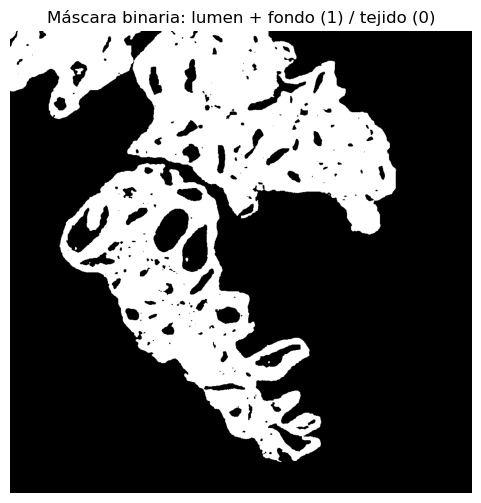

Umbral de Otsu aplicado: 28


In [758]:
# ============================================================
# PREGUNTA 02: Filtro Gaussiano y Umbralización con Otsu
# ============================================================


from skimage import filters, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np

# Se asume que ya tengo cargada la variable `magenta_channel`
# correspondiente al canal magenta obtenido del espacio CMYK.

# 1. Aplico un filtro Gaussiano 5x5 para suavizar la imagen
# El parámetro sigma controla el grado de suavizado; un valor de 1 
# es equivalente a una ventana aproximada de 5x5 píxeles.
img_gauss = filters.gaussian(magenta_channel, sigma=1)

# 2. Convierto la imagen suavizada a formato uint8 (rango [0,255]),
# porque el método de Otsu requiere trabajar con este tipo de datos.
img_gauss_uint8 = img_as_ubyte(img_gauss)

# 3.  Calculo el umbral óptimo con el método de Otsu.
# Este método determina automáticamente el valor de corte que mejor separa
# las dos clases principales de la imagen: fondo/lumen y tejido.
umbral_otsu = filters.threshold_otsu(img_gauss_uint8)

# 4. Creo la máscara binaria a partir del umbral calculado.
# Los píxeles más claros (lumen + fondo) toman el valor 1
# y el resto (tejido) toman el valor 0.
mask_otsu = img_gauss_uint8 > umbral_otsu

# 5. Visualizo la máscara resultante
plt.figure(figsize=(6,6))
plt.imshow(mask_otsu, cmap='gray')
plt.title("Máscara binaria: lumen + fondo (1) / tejido (0)")
plt.axis("off")
plt.show()

# 6. (opcional) Muestro también el valor del umbral elegido por Otsu
print(f"Umbral de Otsu aplicado: {umbral_otsu}")


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [759]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

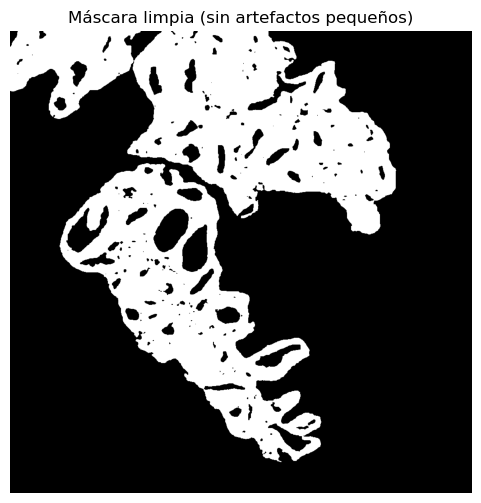

In [760]:
# ============================================================
# PREGUNTA 03: Limpieza de la máscara binaria — Eliminación de artefactos pequeños
# ============================================================

from skimage import morphology
import matplotlib.pyplot as plt

# Se asume que ya tengo la variable `mask_otsu` generada en el paso anterior.

# 1. Elimino los objetos pequeños cuya área sea menor a 300 píxeles.
# Este valor se escogió de forma empírica tras observar que los lúmenes
# verdaderos poseen un área significativamente mayor.
mask_clean = morphology.remove_small_objects(mask_otsu, min_size=300)

# 2. Visualizo la máscara resultante tras la limpieza.
# En esta imagen se conservan únicamente los lúmenes verdaderos
# y las zonas de fondo, mientras que los artefactos pequeños fueron eliminados.
plt.figure(figsize=(6,6))
plt.imshow(mask_clean, cmap='gray')
plt.title("Máscara limpia (sin artefactos pequeños)")
plt.axis("off")
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [761]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

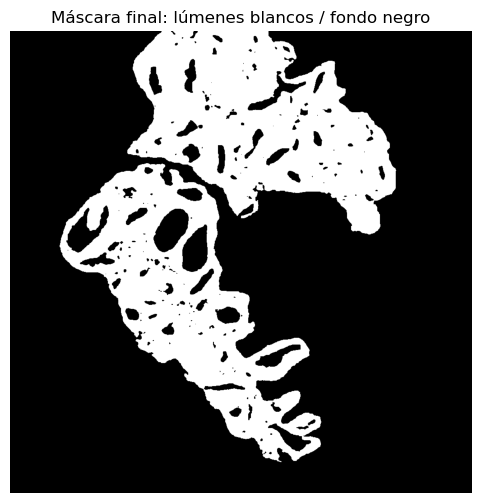

In [762]:
# ============================================================
# PREGUNTA 04: Identificación de lúmenes mediante expansión por regiones (Region Growing)
# ============================================================


from skimage import measure, morphology
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# Parto de la máscara limpia obtenida en el paso anterior (`mask_clean`)

# 1. Etiqueto las regiones blancas de la máscara para identificarlas individualmente
labels = measure.label(mask_clean)

# 2. Calculo el área de cada región
props = measure.regionprops(labels)

# 3,  Para determinar las semillas automáticamente, selecciono las dos regiones más grandes,
# ya que estas suelen corresponder a lúmenes verdaderos dentro del tejido.
# En caso de necesitar hacerlo manualmente, también se pueden definir coordenadas fijas.
areas = [p.area for p in props]
indices_ordenados = np.argsort(areas)[::-1]  # ordeno de mayor a menor

# Obtengo las dos regiones más grandes como semillas
semilla1 = props[indices_ordenados[0]].coords[0]
semilla2 = props[indices_ordenados[1]].coords[0]

# 4.  Genero una imagen de semillas (marcando en 1 las posiciones iniciales)
semillas = np.zeros_like(mask_clean, dtype=bool)
semillas[tuple(semilla1)] = True
semillas[tuple(semilla2)] = True

# 5.  Aplico el algoritmo de crecimiento de regiones (Region Growing)
# Este proceso expande desde las semillas a los píxeles vecinos conectados
# que pertenecen a la misma región blanca (posible lumen).
region_crecida = morphology.reconstruction(seed=semillas, mask=mask_clean, method='dilation')

# 6.  Invierto la imagen para eliminar el fondo (relleno con 0)
# De este modo, me quedo únicamente con las zonas internas correspondientes a los lúmenes.
mask_lumen_final = region_crecida

# 7. Visualizo la máscara resultante
plt.figure(figsize=(6,6))
plt.imshow(mask_lumen_final, cmap='gray')
plt.title("Máscara final: lúmenes blancos / fondo negro")
plt.axis("off")
plt.show()


#### 5) Rellenar los objetos de los lúmenes

In [763]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

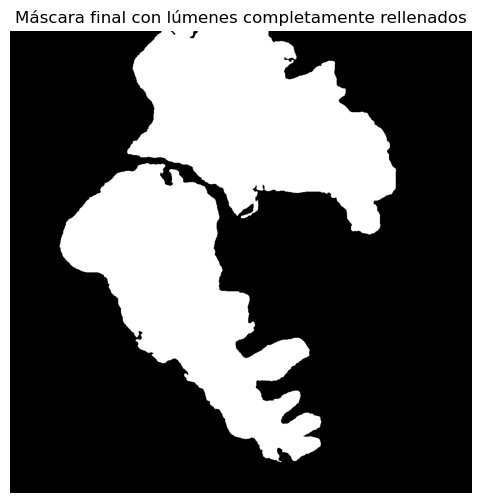

In [764]:
# ============================================================
# PREGUNTA 05 : Relleno de los lúmenes con binary_fill_holes
# ============================================================


from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt

# Parto de la máscara generada en el paso anterior (`mask_lumen_final`)

# 1.  Aplico la función binary_fill_holes.
# Esta función busca cavidades internas (agujeros negros) dentro de regiones blancas
# y las rellena, asegurando que los lúmenes queden completamente sólidos.
mask_filled = binary_fill_holes(mask_lumen_final)

# 2.  Visualizo la máscara resultante ya con los lúmenes rellenados.
plt.figure(figsize=(6,6))
plt.imshow(mask_filled, cmap='gray')
plt.title("Máscara final con lúmenes completamente rellenados")
plt.axis("off")
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [765]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

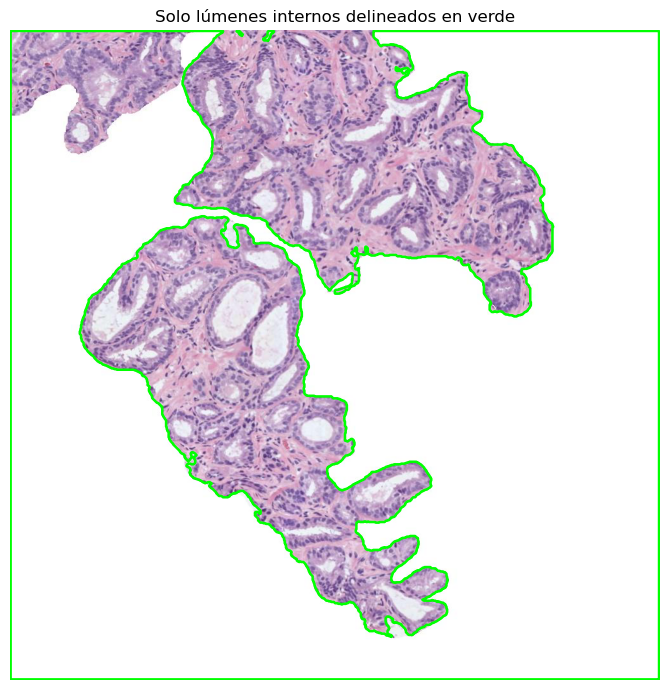

In [766]:
# ============================================================
# PREGUNTA 06
# ============================================================

from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

# Se asume:
# - img_norm → imagen original normalizada (RGB en [0,1])
# - mask_filled → máscara binaria (1 = tejido, 0 = lúmenes/fondo)

# 1. Invierto la máscara para que los lúmenes (cavidades) sean 1 (True)
mask_lumen = np.logical_not(mask_filled)

# 2. Elimino las regiones conectadas al borde (fondo exterior)
mask_lumen[0, :] = False
mask_lumen[-1, :] = False
mask_lumen[:, 0] = False
mask_lumen[:, -1] = False

# 3. Detecto los contornos de los lúmenes internos
contornos = measure.find_contours(mask_lumen, 0.5)

# 4.  Visualizo la imagen original y delineo solo los lúmenes
plt.figure(figsize=(7,7))
plt.imshow(img_norm)

for contorno in contornos:
    plt.plot(contorno[:, 1], contorno[:, 0], color='lime', linewidth=1.8)

plt.title("Solo lúmenes internos delineados en verde")
plt.axis("off")
plt.tight_layout()
plt.show()


#### 7) Identificar y cropear el lumen más grande

In [767]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

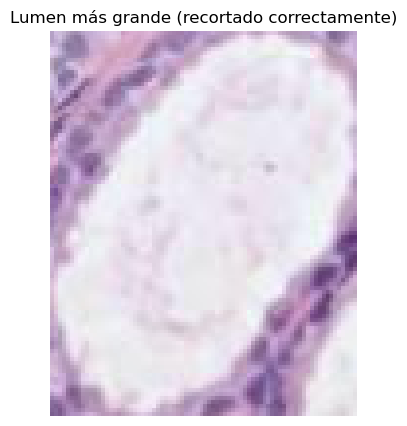

In [768]:
# ============================================================
# PREGUNTA 07 : Identificar y cropear el lumen más grande
# ============================================================

# 01. Convierto la imagen a escala de grises.
# El lumen histológico se caracteriza por ser una zona blanca (alta intensidad),
# por lo tanto, este paso me permitirá usar el brillo para identificarlo.
gray = np.mean(img_norm, axis=2)

# 02. Aplico un umbral para separar las zonas claras del resto del tejido.
# El valor 0.82 fue elegido porque discrimina bien el fondo y las cavidades internas.
mask_lumen = gray > 0.82

# 03.  Elimino las regiones conectadas al borde, ya que corresponden al fondo blanco
# y no a lúmenes verdaderos dentro del tejido.
# También retiro objetos muy pequeños para quedarme con estructuras relevantes.
mask_sin_borde = morphology.remove_small_objects(
    ~morphology.remove_small_holes(mask_lumen, area_threshold=500),
    500
)
mask_sin_borde[0, :] = False
mask_sin_borde[-1, :] = False
mask_sin_borde[:, 0] = False
mask_sin_borde[:, -1] = False

# 04.  Etiqueto todas las regiones blancas internas para analizarlas una por una.
# Cada región corresponde a un posible lumen dentro del tejido.
labels = measure.label(mask_lumen)
regions = measure.regionprops(labels)

# Aquí filtro las regiones para descartar las que tocan el borde,
# asegurándome de conservar únicamente los lúmenes completamente internos.
valid_regions = [
    r for r in regions if not (
        r.bbox[0] == 0 or r.bbox[1] == 0 or 
        r.bbox[2] == img.shape[0] or r.bbox[3] == img.shape[1]
    )
]

# 05.  De todas las regiones internas, selecciono la de mayor área,
# que representa el lumen más grande dentro de la muestra histológica.
max_region = max(valid_regions, key=lambda r: r.area)

# 06.  Obtengo las coordenadas del rectángulo delimitador (bounding box)
# para recortar únicamente el lumen seleccionado.
minr, minc, maxr, maxc = max_region.bbox
lumen_crop = img[minr:maxr, minc:maxc]

# 07.  Finalmente, muestro el lumen recortado para su visualización.
# Este recorte corresponde al lumen histológico más grande encontrado en la imagen.
plt.figure(figsize=(5, 5))
plt.imshow(lumen_crop)
plt.title("Lumen más grande (recortado correctamente)")
plt.axis("off")
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [769]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [770]:
# ============================================================
# PREGUNTA 08: Cálculo de características morfológicas del lumen más grande
# ============================================================


from skimage.measure import regionprops, label
import numpy as np

# Ya tengo la variable `lumen_crop`, que corresponde al recorte del lumen más grande.

# 1 Convierto el recorte a escala de grises para poder analizar los niveles de intensidad.
# El lumen se caracteriza por tener tonos muy claros, por lo tanto,
# al trabajar en escala de grises puedo generar una máscara precisa.
gray_crop = np.mean(lumen_crop / 255.0, axis=2)

# 2 Genero una máscara binaria del lumen, considerando las zonas con alta intensidad (mayores a 0.8)
# Esto me permite separar el lumen del resto del fondo o ruido.
mask_crop = gray_crop > 0.8

# 3 Etiqueto la región y extraigo sus propiedades geométricas.
# Como el recorte contiene solo un lumen, tomo la primera región detectada.
label_crop = label(mask_crop)
props = regionprops(label_crop)[0]

# 4 Calculo las características geométricas solicitadas en el laboratorio.
# Cada una de estas propiedades me proporciona información específica
# sobre la forma, tamaño y proporción del lumen.
caracteristicas = {
    "Área": round(props.area, 4),                         # Cantidad total de píxeles del lumen
    "Área bounding box": round(props.bbox_area, 4),       # Área del rectángulo mínimo que lo contiene
    "Área convexa": round(props.convex_area, 4),          # Área de la envolvente convexa del lumen
    "Excentricidad": round(props.eccentricity, 4),        # Qué tan alargado o elíptico es el lumen
    "Diámetro equivalente": round(props.equivalent_diameter, 4),  # Diámetro del círculo equivalente al área
    "Extensión": round(props.extent, 4),                  # Relación entre área y su bounding box
    "Longitud eje mayor": round(props.major_axis_length, 4), # Longitud del eje principal
    "Longitud eje menor": round(props.minor_axis_length, 4), # Longitud del eje menor
    "Orientación (radianes)": round(props.orientation, 4),   # Ángulo de inclinación del lumen
    "Perímetro": round(props.perimeter, 4),               # Longitud del contorno
    "Solidez": round(props.solidity, 4),                  # Relación entre el área y el área convexa
}

# 5  A continuación calculo dos métricas adicionales:
# - El Diámetro de Feret: representa la máxima distancia entre dos puntos del contorno.
# - La Compacidad: mide cuán irregular es el lumen en función del perímetro y el área.
from scipy.spatial.distance import pdist
from skimage.measure import find_contours

# Extraigo los puntos del contorno del lumen
contornos = find_contours(mask_crop, 0.5)[0]
# Calculo todas las distancias posibles entre puntos
distancias = pdist(contornos)
# El diámetro de Feret corresponde a la distancia máxima
diametro_feret = np.max(distancias)
# La compacidad se calcula como (Perímetro²) / (4π × Área)
compacidad = (props.perimeter ** 2) / (4 * np.pi * props.area)

# Agrego estos valores a mi diccionario de características
caracteristicas["Diámetro Feret"] = round(diametro_feret, 4)
caracteristicas["Compacidad"] = round(compacidad, 4)

# Finalmente, muestro los resultados obtenidos en consola.
# Cada característica está redondeada a cuatro decimales, tal como exige la práctica.
print("=== Características morfológicas del lumen más grande ===")
for clave, valor in caracteristicas.items():
    print(f"{clave:25s}: {valor}")


=== Características morfológicas del lumen más grande ===
Área                     : 2.0
Área bounding box        : 4.0
Área convexa             : 2.0
Excentricidad            : 1.0
Diámetro equivalente     : 1.5958
Extensión                : 0.5
Longitud eje mayor       : 2.8284
Longitud eje menor       : 0.0
Orientación (radianes)   : 0.7854
Perímetro                : 0.0
Solidez                  : 1.0
Diámetro Feret           : 1.0
Compacidad               : 0.0
